# Задача: построить модель, которая предскажет температуру стали на последнем этапе. (Метрика MAE<= 6.8 )

## Описание данных

Данные состоят из файлов, полученных из разных источников:

- data_arc_new.csv — данные об электродах;
- data_bulk_new.csv — данные о подаче сыпучих материалов (объём);
- data_bulk_time_new.csv — данные о подаче сыпучих материалов (время);
- data_gas_new.csv — данные о продувке сплава газом;
- data_temp_new.csv — результаты измерения температуры;
- data_wire_new.csv — данные о проволочных материалах (объём);
- data_wire_time_new.csv — данные о проволочных материалах (время).

Во всех файлах столбец key содержит номер партии. В файлах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.

In [1]:
pip install shap

     |████████████████████████████████| 572 kB 2.6 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor, plot_importance
from catboost import CatBoostRegressor

In [3]:
data_arc_new = pd.read_csv('/datasets/data_arc_new.csv')
data_bulk_new = pd.read_csv('/datasets/data_bulk_new.csv')
data_bulk_time_new = pd.read_csv('/datasets/data_bulk_time_new.csv')
data_gas_new = pd.read_csv('/datasets/data_gas_new.csv')
data_temp_new = pd.read_csv('/datasets/data_temp_new.csv')
data_wire_new = pd.read_csv('/datasets/data_wire_new.csv')
data_wire_time_new = pd.read_csv('/datasets/data_wire_time_new.csv')

In [4]:
data_arc_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [5]:
data_arc_new.describe()

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284


In [6]:
display(data_arc_new.head())

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


In [7]:
data_bulk_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [8]:
data_bulk_new.describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


In [9]:
display(data_bulk_new.head())

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [10]:
data_bulk_time_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [11]:
data_bulk_time_new.describe()

,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


In [12]:
display(data_bulk_time_new.head())

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47


In [13]:
data_gas_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [14]:
data_gas_new.describe()

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


In [15]:
display(data_gas_new.head())

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [16]:
data_temp_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


In [17]:
data_temp_new.describe()

,key,Температура
count,18092.000000,14665.000000
mean,1616.460977,1590.722741
std,934.641385,20.394381
min,1.000000,1191.000000
25%,807.750000,1580.000000
50%,1618.000000,1590.000000
75%,2429.000000,1599.000000
max,3241.000000,1705.000000


In [18]:
display(data_temp_new.head())

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


In [19]:
data_wire_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [20]:
data_wire_new.describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


In [21]:
display(data_wire_new.head())

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
data_wire_time_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


In [23]:
data_wire_time_new.describe()

,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


In [24]:
display(data_wire_time_new.head())

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Text(0, 0.5, 'кол-во партий')

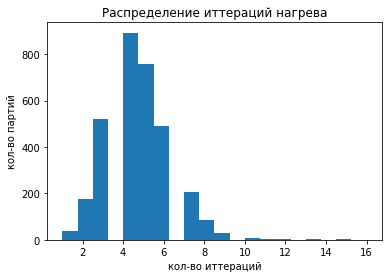

In [25]:
plt.hist(data_arc_new['key'].value_counts(), bins=20)
plt.title('Распределение иттераций нагрева')
plt.xlabel('кол-во иттераций')
plt.ylabel('кол-во партий')

Text(0, 0.5, 'кол-во партий')

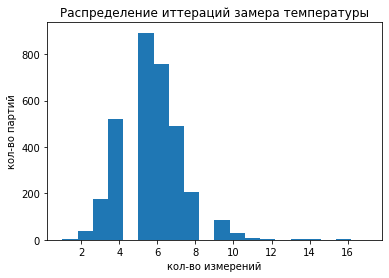

In [26]:
plt.hist(data_temp_new['key'].value_counts(), bins=20)
plt.title('Распределение иттераций замера температуры')
plt.xlabel('кол-во измерений')
plt.ylabel('кол-во партий')

Text(0.5, 0, 'температура')

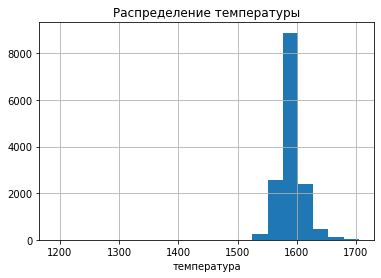

In [27]:
data_temp_new['Температура'].hist(bins=20)
plt.title('Распределение температуры')
plt.xlabel('температура')

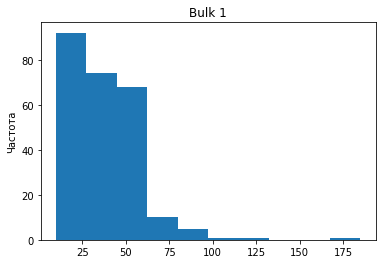

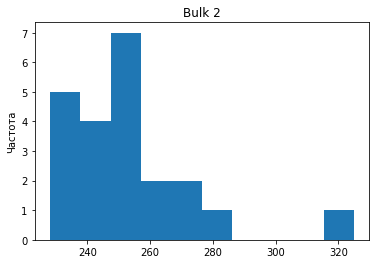

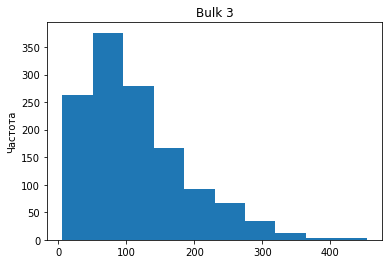

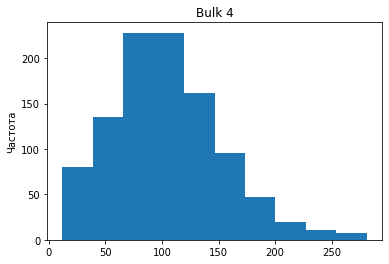

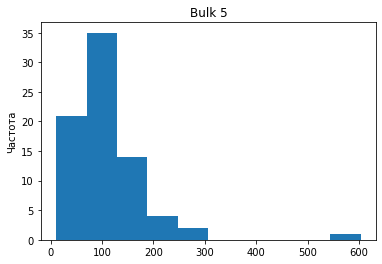

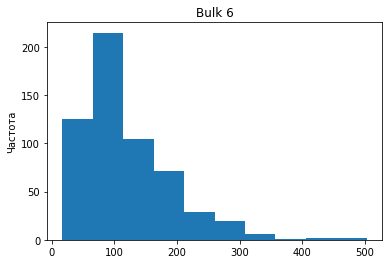

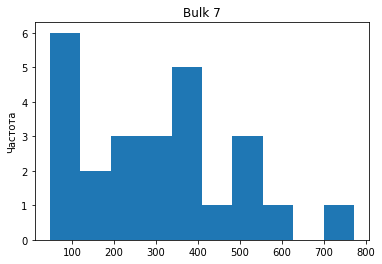

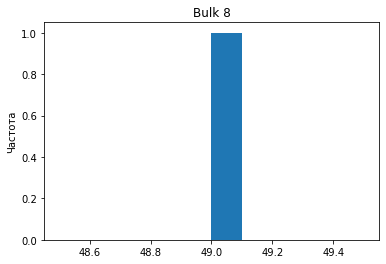

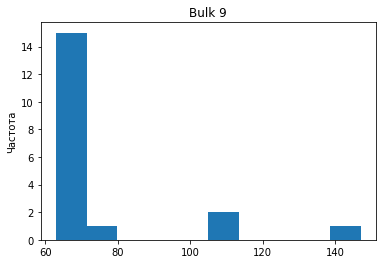

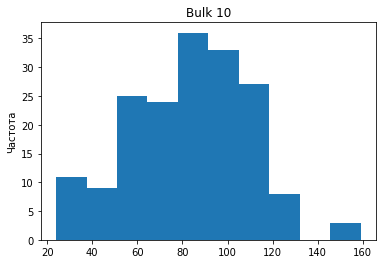

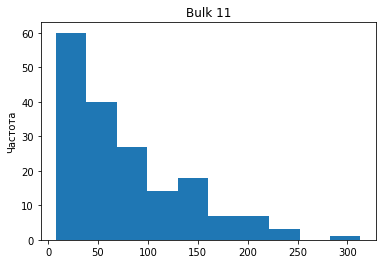

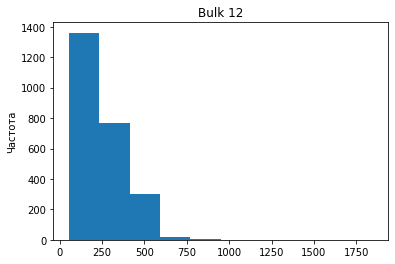

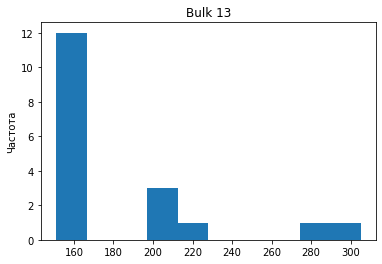

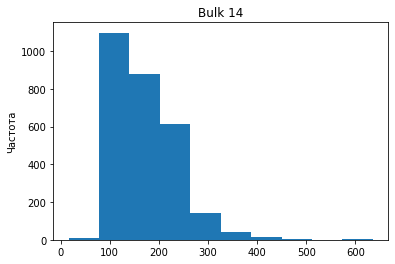

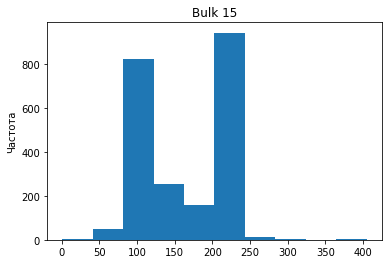

In [28]:
for i in ['Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6',
       'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12',
       'Bulk 13', 'Bulk 14', 'Bulk 15']:
    plt.hist(data_bulk_new[f'{i}'])
    plt.title(f'{i}')
    plt.ylabel('Частота')
    plt.show()

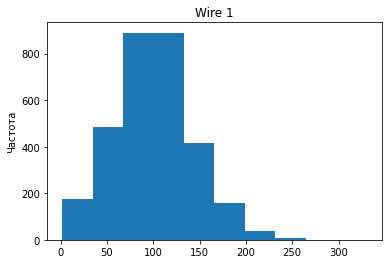

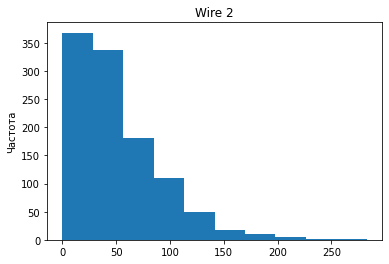

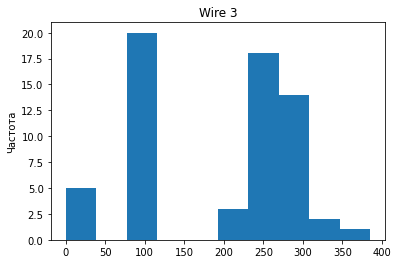

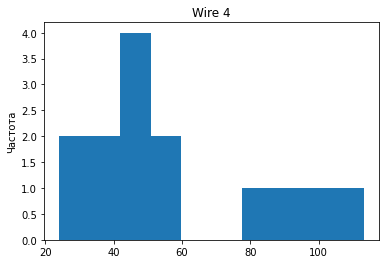

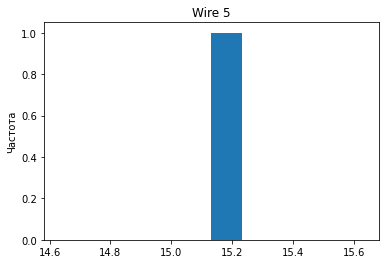

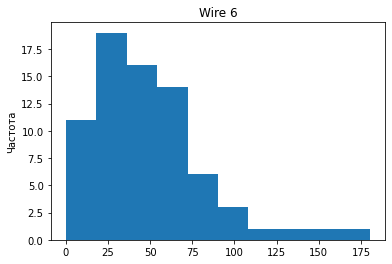

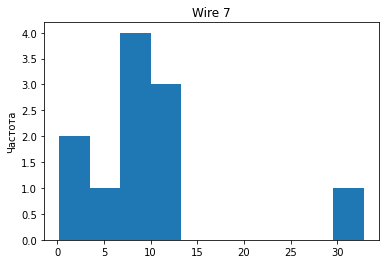

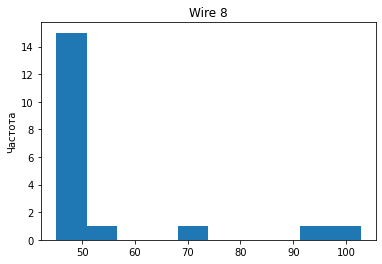

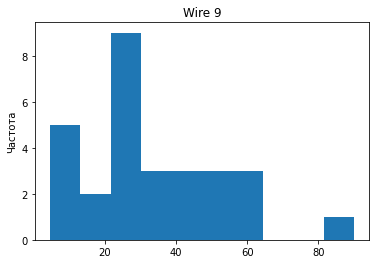

In [29]:
for i in ['Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6',
       'Wire 7', 'Wire 8', 'Wire 9']:
    plt.hist(data_wire_new[f'{i}'])
    plt.title(f'{i}')
    plt.ylabel('Частота')
    plt.show()

**Общие выводы:**

- Много пропусков в bulk и wire т.к. скорее всего не все материалы нужны для каждой партии по тех процессу. Далее пропуски заполним нулями.
- В data_temp пропуски в столбце температура. Далее будет исключать партии где нет этих данных.
- В data_arc_new в столбце реактивная мощность есть отрицательные значение. Далее с агрегируем реактивную и активную мощность в полную по формуле S = (Q**2 +S**2)**1/2.


## План

- Исходя из ответов на вопросы возниших на этапе описания данных сделаем предобработку данных(пропукски, отрицательные значения и т.д.)
- Необходимо будет сделать общий датасет для обучения моделей и выделить целевой признак
- Провести анализ на мультиколлинеарность перед моделированием
- Провести моделирование используя LinearRegression, CatBoostRegressor, LGBMRegressor и по метрики MAE определить лучшую модель
- Сделать окончательные выводы по результатам на тестовой выборке лучшей модели
- Сделать анализ важности факторов у лучшей модели

## Предобработка данных

**Расчет полной мощности**

In [30]:
def full_power(row):
    return (row['Активная мощность']**2 + row['Реактивная мощность']**2)**0.5

In [31]:
data_arc_new['Полная мощность'] = data_arc_new.apply(full_power, axis=1)

**Исключаем Активную и Реактивную мощности**

In [32]:
data_arc_new = data_arc_new.drop(['Активная мощность', 'Реактивная мощность'], axis=1)

In [33]:
data_arc_new.columns

Index(['key', 'Начало нагрева дугой', 'Конец нагрева дугой',
       'Полная мощность'],
      dtype='object')

**Добавим общюю длительность нагрева в мин**

In [34]:
data_arc_new['Начало нагрева дугой'] = pd.to_datetime(data_arc_new['Начало нагрева дугой'])
data_arc_new['Конец нагрева дугой'] = pd.to_datetime(data_arc_new['Конец нагрева дугой'])

In [35]:
data_arc_new['Продолжительность нагрева'] = data_arc_new['Конец нагрева дугой'] - data_arc_new['Начало нагрева дугой']
data_arc_new['Продолжительность в минутах'] = data_arc_new['Продолжительность нагрева'] / np.timedelta64(1, "m")

In [36]:
data_arc_new = data_arc_new.drop(['Начало нагрева дугой', 'Конец нагрева дугой', 'Продолжительность нагрева'], axis=1)

In [37]:
data_arc_new.head()

,key,Полная мощность,Продолжительность в минутах
0,1,0.371123,3.800000
1,1,0.902319,3.083333
2,1,0.722536,2.866667
3,1,0.642824,6.083333
4,1,1.079934,2.466667


**Группируем по key и получаем суммарную полную мощность, суммарную продолжительность нагрева и кол-во иттераций нагрева**

In [38]:
group_arc = data_arc_new.groupby('key').agg({'Полная мощность':'sum', 
                                            'Продолжительность в минутах':['sum', 'count']},
                                                 ).reset_index()

group_arc.set_axis(['key', 'Полная мощность', 'Суммарная продолжительность',
                    'Иттерации нагрева'], axis='columns', inplace=True)

In [39]:
group_arc.head()

,key,Полная мощность,Суммарная продолжительность,Иттерации нагрева
0,1,3.718736,18.300000,5
1,2,2.588349,13.516667,4
2,3,5.019223,10.916667,5
3,4,3.400038,12.350000,4
4,5,2.816980,14.483333,4


**Выделяем первоначальную температуру как признак и конечную, как целевой признак**

In [40]:
group_temp = data_temp_new.groupby('key').count()
group_temp['Температура'][group_temp['Температура'] < 2]

key
195     1
279     1
2500    1
2501    1
2502    1
       ..
3237    1
3238    1
3239    1
3240    1
3241    1
Name: Температура, Length: 741, dtype: int64

In [41]:
data_temp_new.columns

Index(['key', 'Время замера', 'Температура'], dtype='object')

**Удалим партии где только один замер температуры**

In [42]:
keys_one_temp = list(group_temp['Температура'][group_temp['Температура'] < 2].index)
data_temp_new = data_temp_new.query('key not in @keys_one_temp')

**Для каждой партии найдем начало и конец замера температуры**

In [43]:
data_temp_new['Время замера'] = pd.to_datetime(data_temp_new['Время замера'])

first_temp = data_temp_new.groupby('key').agg({'Время замера':'min'})
target_key = data_temp_new.groupby('key').agg({'Время замера':'max'})

**Получаем целевой признак(конечная температура)**

In [44]:
target = data_temp_new.merge(target_key, on='Время замера')
target.shape

(2475, 3)

**Получаем начальную температуру**

In [45]:
data_temp_new = data_temp_new.merge(first_temp, on='Время замера')
data_temp_new.shape

(2475, 3)

In [46]:
data_temp_new = data_temp_new.rename(columns={'Температура':'Начальная температура'})

In [47]:
data_temp_new

,key,Время замера,Начальная температура
0,1,2019-05-03 11:02:04,1571.0
1,2,2019-05-03 11:34:04,1581.0
2,3,2019-05-03 12:06:44,1596.0
3,4,2019-05-03 12:39:27,1601.0
4,5,2019-05-03 13:11:03,1576.0
...,...,...,...
2470,2495,2019-08-10 11:27:47,1570.0
2471,2496,2019-08-10 11:56:48,1554.0
2472,2497,2019-08-10 12:37:26,1571.0
2473,2498,2019-08-10 12:58:11,1591.0


### Формируем общую таблицу

- объединяем все таблицы по key
- проверим итоговую таблицу

In [48]:
features = data_temp_new \
               .merge(group_arc, on='key', how='inner') \
               .merge(data_gas_new, on='key', how='inner') \
               .merge(data_bulk_new, on='key', how='inner') \
               .merge(data_wire_new, on='key', how='inner')

features.shape

(2329, 31)

In [49]:
features.head(2)

,key,Время замера,Начальная температура,Полная мощность,Суммарная продолжительность,Иттерации нагрева,Газ 1,Bulk 1,Bulk 2,Bulk 3,...,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:02:04,1571.0,3.718736,18.300000,5,29.749986,NaN,NaN,NaN,...,154.0,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:34:04,1581.0,2.588349,13.516667,4,12.555561,NaN,NaN,NaN,...,154.0,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 0 to 2328
Data columns (total 31 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   key                          2329 non-null   int64         
 1   Время замера                 2329 non-null   datetime64[ns]
 2   Начальная температура        2329 non-null   float64       
 3   Полная мощность              2329 non-null   float64       
 4   Суммарная продолжительность  2329 non-null   float64       
 5   Иттерации нагрева            2329 non-null   int64         
 6   Газ 1                        2329 non-null   float64       
 7   Bulk 1                       199 non-null    float64       
 8   Bulk 2                       13 non-null     float64       
 9   Bulk 3                       960 non-null    float64       
 10  Bulk 4                       812 non-null    float64       
 11  Bulk 5                       53 non-null   

**Удаляем столбцы где нет данных или слишком мало данных (менее 20) и столбец Время замера**

In [51]:
features = features.drop(['Bulk 2', 'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 13', 
                          'Wire 4', 'Wire 5', 'Wire 7', 'Wire 8', 'Время замера'], axis=1)

**Пропуски в присадках заполняем нулями**

In [52]:
features = features.fillna(0)
features.head(2)

,key,Начальная температура,Полная мощность,Суммарная продолжительность,Иттерации нагрева,Газ 1,Bulk 1,Bulk 3,Bulk 4,Bulk 5,...,Bulk 10,Bulk 11,Bulk 12,Bulk 14,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 6,Wire 9
0,1,1571.0,3.718736,18.300000,5,29.749986,0.0,0.0,43.0,0.0,...,0.0,0.0,206.0,150.0,154.0,60.059998,0.0,0.0,0.0,0.0
1,2,1581.0,2.588349,13.516667,4,12.555561,0.0,0.0,73.0,0.0,...,0.0,0.0,206.0,149.0,154.0,96.052315,0.0,0.0,0.0,0.0


**Подтянем целевую под партии и удалим столбцы key  и  Время замера**

In [53]:
keys = list(features['key'].unique())
target = target.query('key in @keys').drop(['key', 'Время замера'], axis=1)

**Сравним размеры таблицы с признаками и целевой**

In [54]:
print('размер датасета с признаками', features.shape)
print('размер таргета', target.shape)

размер датасета с признаками (2329, 21)
размер таргета (2329, 1)


In [55]:
features.head(5)

,key,Начальная температура,Полная мощность,Суммарная продолжительность,Иттерации нагрева,Газ 1,Bulk 1,Bulk 3,Bulk 4,Bulk 5,...,Bulk 10,Bulk 11,Bulk 12,Bulk 14,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 6,Wire 9
0,1,1571.0,3.718736,18.300000,5,29.749986,0.0,0.0,43.0,0.0,...,0.0,0.0,206.0,150.0,154.0,60.059998,0.00000,0.0,0.0,0.0
1,2,1581.0,2.588349,13.516667,4,12.555561,0.0,0.0,73.0,0.0,...,0.0,0.0,206.0,149.0,154.0,96.052315,0.00000,0.0,0.0,0.0
2,3,1596.0,5.019223,10.916667,5,28.554793,0.0,0.0,34.0,0.0,...,0.0,0.0,205.0,152.0,153.0,91.160157,0.00000,0.0,0.0,0.0
3,4,1601.0,3.400038,12.350000,4,18.841219,0.0,0.0,81.0,0.0,...,0.0,0.0,207.0,153.0,154.0,89.063515,0.00000,0.0,0.0,0.0
4,5,1576.0,2.816980,14.483333,4,5.413692,0.0,0.0,78.0,0.0,...,0.0,0.0,203.0,151.0,152.0,89.238236,9.11456,0.0,0.0,0.0


### Анализируем на мультиколлинеарность

In [56]:
features.corr()

,key,Начальная температура,Полная мощность,Суммарная продолжительность,Иттерации нагрева,Газ 1,Bulk 1,Bulk 3,Bulk 4,Bulk 5,...,Bulk 10,Bulk 11,Bulk 12,Bulk 14,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 6,Wire 9
key,1.000000,-0.019186,0.022669,-0.029358,-0.033268,-0.043486,-0.078236,-0.007271,-0.026147,0.035212,...,0.062875,0.034924,0.025958,-0.110275,-0.045531,-0.013564,0.043149,-0.027270,-0.008236,0.021312
Начальная температура,-0.019186,1.000000,-0.017907,-0.305086,-0.141478,0.037341,0.072331,-0.104394,0.144775,0.068389,...,0.035408,-0.087791,-0.058495,-0.131024,-0.040349,0.209444,-0.086089,-0.000178,0.019884,0.004310
Полная мощность,0.022669,-0.017907,1.000000,0.050750,0.081226,0.038491,0.004317,-0.002515,-0.012610,0.005028,...,-0.003988,0.002773,0.001816,0.041734,-0.011982,0.001200,-0.004456,0.003233,0.003347,-0.004174
Суммарная продолжительность,-0.029358,-0.305086,0.050750,1.000000,0.798897,0.396379,0.103027,0.092612,-0.028329,0.013519,...,-0.005031,0.078171,0.466688,0.461335,0.295711,0.055419,0.054481,0.033399,0.042288,-0.011585
Иттерации нагрева,-0.033268,-0.141478,0.081226,0.798897,1.000000,0.404036,0.097734,0.109092,-0.004408,0.075008,...,0.012659,0.062565,0.306937,0.334118,0.174703,0.138141,0.078113,0.055257,0.053383,-0.024577
Газ 1,-0.043486,0.037341,0.038491,0.396379,0.404036,1.000000,0.234141,0.059628,0.017578,0.086902,...,-0.008508,0.042027,0.217332,0.268889,0.043624,0.117313,0.104248,0.103382,0.108089,0.014070
Bulk 1,-0.078236,0.072331,0.004317,0.103027,0.097734,0.234141,1.000000,-0.011628,0.041846,0.060429,...,-0.023187,-0.037892,0.325771,0.207718,-0.000800,0.013682,-0.009229,0.020271,0.148561,0.011066
Bulk 3,-0.007271,-0.104394,-0.002515,0.092612,0.109092,0.059628,-0.011628,1.000000,-0.295431,-0.006801,...,-0.085186,-0.007445,0.018371,0.010772,-0.012860,0.039637,0.095723,0.005780,0.007113,0.004621
Bulk 4,-0.026147,0.144775,-0.012610,-0.028329,-0.004408,0.017578,0.041846,-0.295431,1.000000,0.028348,...,-0.084746,-0.119529,0.105791,-0.090602,0.101514,0.297591,-0.268142,-0.039219,-0.011417,-0.058138
Bulk 5,0.035212,0.068389,0.005028,0.013519,0.075008,0.086902,0.060429,-0.006801,0.028348,1.000000,...,-0.028480,-0.015840,-0.072758,-0.065890,-0.067190,-0.013493,-0.013794,0.070916,0.204819,-0.010817


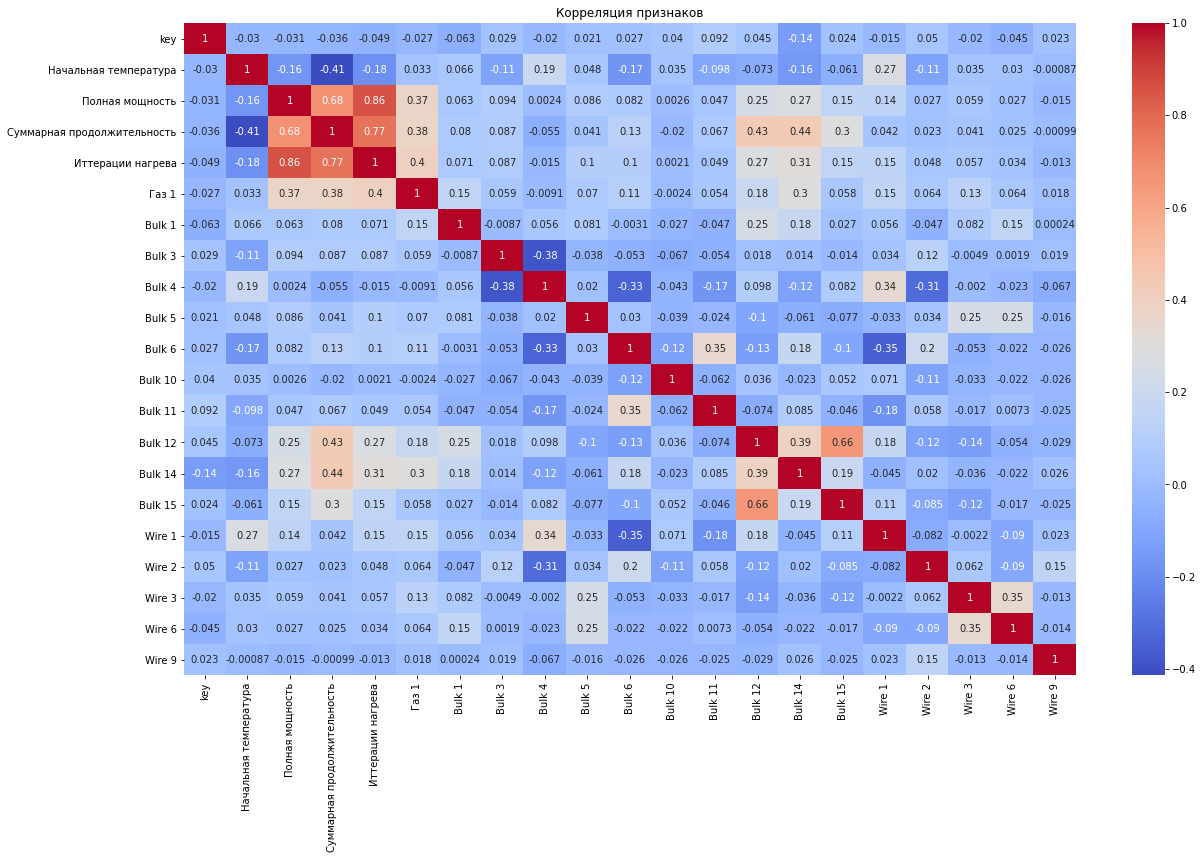

In [57]:
plt.figure(figsize=(20, 12))
plt.title('Корреляция признаков')
sns.heatmap(features.corr(method='spearman'), annot = True, cmap="coolwarm")
plt.show()

**Удалим из фичей key**

In [58]:
features = features.drop(['key'], axis=1)

In [59]:
feature_names = list(features.columns)
feature_names

['Начальная температура',
 'Полная мощность',
 'Суммарная продолжительность',
 'Иттерации нагрева',
 'Газ 1',
 'Bulk 1',
 'Bulk 3',
 'Bulk 4',
 'Bulk 5',
 'Bulk 6',
 'Bulk 10',
 'Bulk 11',
 'Bulk 12',
 'Bulk 14',
 'Bulk 15',
 'Wire 1',
 'Wire 2',
 'Wire 3',
 'Wire 6',
 'Wire 9']

## Подбор модели

**Выделим тестовую выборку и тренировочную**

In [60]:
RANDOM_STATE = 22052023

In [61]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM_STATE)

In [62]:
print('Размер обучающей выборки', features_train.shape)
print('Размер тестовой выборки', features_test.shape)

print('Размер трейн таргета', target_train.shape)
print('Размер тестового таргета', target_test.shape)

Размер обучающей выборки (1746, 20)
Размер тестовой выборки (583, 20)
Размер трейн таргета (1746, 1)
Размер тестового таргета (583, 1)


**Маштабируем признаки**

In [63]:
scaler = StandardScaler().fit(features_train)

features_train = scaler.transform(features_train)
features_test = scaler.transform(features_test)

**Создадим сводный словарь для результатов**

In [64]:
results = {
    'Constant_mean': [],
    'LinearRegression': [],
    'CatBoost': [],
    'LGBM': [],   
}

### Константная модель

In [65]:
const_predict = np.array([int(target_test.mean())] * int(target_test.count()))

results['Constant_mean'].append(mean_absolute_error(target_test, const_predict))

results

{'Constant_mean': [8.768439108061749],
 'LinearRegression': [],
 'CatBoost': [],
 'LGBM': []}

### LinearRegression модель

**Кросс валидацией определяем лучший показатель метрики МАЕ**

In [66]:
scores = cross_val_score(LinearRegression(), 
                         features_train, target_train, 
                         cv=5, scoring='neg_mean_absolute_error',
                        )
print(-np.mean(scores))

6.569637488265502


In [67]:
results['LinearRegression'].append(-np.mean(scores))

### CatBoostRegressor модель

In [68]:
scores = cross_val_score(CatBoostRegressor(random_state=RANDOM_STATE, silent=True), 
                         features_train, target_train, 
                         cv=5, scoring='neg_mean_absolute_error',
                        )
print(-np.mean(scores))

6.154991184608758


parameters = {'learning_rate': [0.03, 0.1, 0.2],
        'depth': [i for i in range(2, 6)],
        'l2_leaf_reg': [i for i in range(1, 5)],
        'iterations': [i for i in range(100, 500, 50)],
         }

model = CatBoostRegressor(random_state=RANDOM_STATE, loss_function='MAE', silent=True)

grid_search = GridSearchCV(model, parameters, scoring='neg_mean_absolute_error')

grid_search.fit(features_train, target_train)

print("Лучшие гиперпараметры:", grid_search.best_params_)
print("Лучший результат:", grid_search.best_score_)

Лучшие гиперпараметры: {'depth': 5, 'iterations': 450, 'l2_leaf_reg': 3, 'learning_rate': 0.03}
Лучший результат: -5.970519888135045

In [69]:
results['CatBoost'].append(-np.mean(scores))

### LGBMRegressor модель

In [70]:
scores = cross_val_score(LGBMRegressor(random_state=RANDOM_STATE), 
                         features_train, target_train, 
                         cv=5, scoring='neg_mean_absolute_error')

print(-np.mean(scores))

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


6.417901488302495


In [71]:
results['LGBM'].append(-np.mean(scores))

In [72]:
results

{'Constant_mean': [8.768439108061749],
 'LinearRegression': [6.569637488265502],
 'CatBoost': [6.154991184608758],
 'LGBM': [6.417901488302495]}

In [73]:
pd.DataFrame(results, columns=results.keys(), index=['train (MAE)'])

,Constant_mean,LinearRegression,CatBoost,LGBM
train (MAE),8.768439,6.569637,6.154991,6.417901


**Вывод**

- Лучшая модель с метрикой МАЕ на тестовой выборке CatBoost

## Проверка на тестовой выборке

In [74]:
cat_model = CatBoostRegressor(random_state=RANDOM_STATE, 
                              loss_function="MAE", 
                              depth=5, l2_leaf_reg=3, 
                              iterations=450, learning_rate=0.03
                             )

cat_model.fit(features_train, target_train)

cat_prediction = cat_model.predict(features_test)

cat_mae = mean_absolute_error(target_test, cat_prediction)



0:	learn: 7.7577482	total: 2.33ms	remaining: 1.04s
1:	learn: 7.6902114	total: 4.27ms	remaining: 957ms
2:	learn: 7.6530255	total: 5.99ms	remaining: 892ms
3:	learn: 7.6099708	total: 7.69ms	remaining: 857ms
4:	learn: 7.5641007	total: 9.43ms	remaining: 839ms
5:	learn: 7.5280270	total: 11.2ms	remaining: 831ms
6:	learn: 7.4901622	total: 13.1ms	remaining: 826ms
7:	learn: 7.4568416	total: 14.9ms	remaining: 821ms
8:	learn: 7.4223709	total: 16.7ms	remaining: 817ms
9:	learn: 7.3891230	total: 18.4ms	remaining: 809ms
10:	learn: 7.3659494	total: 20.2ms	remaining: 805ms
11:	learn: 7.3290252	total: 21.8ms	remaining: 797ms
12:	learn: 7.2925259	total: 23.7ms	remaining: 795ms
13:	learn: 7.2494528	total: 25.3ms	remaining: 789ms
14:	learn: 7.2147789	total: 27ms	remaining: 783ms
15:	learn: 7.1768101	total: 28.6ms	remaining: 776ms
16:	learn: 7.1508046	total: 30.2ms	remaining: 769ms
17:	learn: 7.1267703	total: 31.8ms	remaining: 764ms
18:	learn: 7.1043569	total: 33.5ms	remaining: 761ms
19:	learn: 7.0794882	tot

In [75]:
print('MAE на тестовой выборке:', cat_mae)

MAE на тестовой выборке: 6.623187942485103


**Выводы**

- Лучшая модель  CatBoost c парамметрами {'depth': 5, 'iterations': 450, 'l2_leaf_reg': 3, 'learning_rate': 0.03} показала на тестовой выборке MAE = 6.62, что удовлитворяет поставленной задаче.

## Проверка значимости признаков

In [76]:
explainer = shap.Explainer(cat_model)

In [77]:
shap_values = explainer.shap_values(features_train)

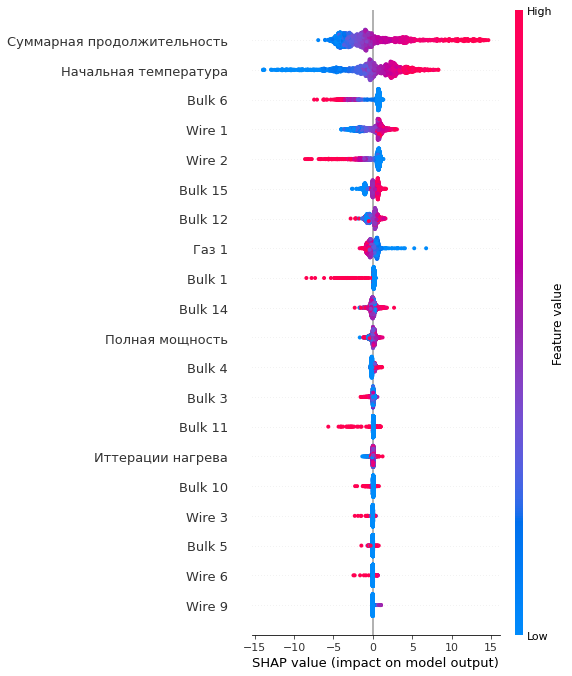

In [78]:
shap.summary_plot(shap_values, features_train, feature_names=feature_names)


**Вывод**

- Наибольшее значение и влияние на модель оказывают признаки Суммарная продолжительность и Начальная температура



## Отчет

**Основные вопросы**

- Какие пункты плана были выполнены, а какие нет?
- Какие трудности возникли и как вы их преодолели?
- Какие ключевые шаги в решении задачи вы выделили?
- Какая ваша итоговая модель, какие у неё гиперпараметы и какое качество?

**Были выполнены следующие пункты плана**

- Загружены данные (датасеты: data_arc_new, data_bulk_new, data_bulk_time_new, data_gas_new, data_temp_new, data_wire_new и data_wire_time_new) и проведенна преобработка
- Был сформирован общий датасет для обучения моделей (features) и выделен целевой признак (target)
- Проведен анализ на мультиколлинеарность перед моделированием
- Проведено моделирование используя LinearRegression, CatBoostRegressor, LGBMRegressor и по метрики MAE определили лучшую модель( CatBoost {'depth': 5, 'iterations': 450, 'l2_leaf_reg': 3, 'learning_rate': 0.03}) 
- Сделали окончательные выводы по результатам на тестовой выборке лучшей модели CatBoost. MAE = 6.62
- Сделали анализ важности факторов SHAP у лучшей модели.

**Возникли следующие трудности**

- Было не сразу понятно по пропускам в датасетах и где взять целевой признак. Понимание было достигнуто на первой встрече с тимлидом Николаем.
- Было не понятно как обработать признаки мощности (активная, реактивная). Понимание было достигнуто на первой встрече с тимлидом Николаем. Решение - ввели Полную мощность и убрали Активную с Реактивной.

**Мы выделили следующие ключевые шаги**

- Загрузка и преобработка датасетов
- Формирование датасета с фичами и целевого признака для моделирования
- Проверка на мультиколленеарность перед моделированием
- Тренировка несколько моделей (LR, CT, LGBM) и пометрики МАЕ отбор лучшей модели
- Проверка лучшей модели тестовой выборке на предмет что бы MAE было <= 6.8
- Проверка на значимость признаков SHAP для лучшей модели 

**Итоговая модель**

- Лучшие показатели на тренировочных данных по метрики MAE = 6.15 показала модель CatBoost. (RANDOM_STATE = 22052023)
- Лучшие параметры для CatBoost {'depth': 5, 'iterations': 450, 'l2_leaf_reg': 3, 'learning_rate': 0.03} опрпеделены с помощью GridSearchCV
- CatBoost {'depth': 5, 'iterations': 450, 'l2_leaf_reg': 3, 'learning_rate': 0.03} показала на тестовой выборке МАЕ=6.62

**Список признаков (по значимости сверху вниз) и их предобработка**

- Суммарная продолжительность: это продолжительность нагрева в минутах. Получили данный признак в датасете data_arc_new путем вычитания из времени конца нагрева дугой времени начала нагрева дугой, а затем группирования по key.
- Начальная температура: получили данный признак путем слияния (merge) двух датафреймов data_temp_new и first_temp на основе столбца 'Время замера'. first_temp было получен ранее из data_temp_new 
- Bulk 6: полумен из data_bulk_new, где пропуски заполнены нулями.
- Wire 1: полумен из data_wire_new, где пропуски заполнены нулями.
- Wire 2: полумен из data_wire_new, где пропуски заполнены нулями.
- Bulk 15: полумен из data_bulk_new, где пропуски заполнены нулями.
- Bulk 12: полумен из data_bulk_new, где пропуски заполнены нулями.
- Газ 1: полумен из data_gas_new
- Bulk 1: полумен из data_bulk_new, где пропуски заполнены нулями.
- Bulk 14: полумен из data_bulk_new, где пропуски заполнены нулями.
- Полная мощность: получен из data_arc_new по формуле $ S= \sqrt{Q^2 + P^2} $ 
- Bulk 4: полумен из data_bulk_new, где пропуски заполнены нулями.
- Bulk 3: полумен из data_bulk_new, где пропуски заполнены нулями.
- Bulk 11: полумен из data_bulk_new, где пропуски заполнены нулями.
- Иттерации нагрева: получен из data_arc_new при группировании по key.
- Bulk 10: полумен из data_bulk_new, где пропуски заполнены нулями.
- Wire 3: полумен из data_wire_new, где пропуски заполнены нулями.
- Bulk 5: полумен из data_bulk_new, где пропуски заполнены нулями.
- Wire 6: полумен из data_wire_new, где пропуски заполнены нулями.
- Wire 9: полумен из data_wire_new, где пропуски заполнены нулями.

**Рекомендации для улучшения модели**

- Для повышения точности модели можно еще поработать (на предмет аномалий и выбросов например) с признаками Суммарная продолжительность и Начальная температура т.к. они максимально положительно и отрицательно воздействуют на модель.
- Можно было бы выделить в отдельную группу данные выходящие за пределы "нормальности" так сказать и проанализировать возможные причины влияния с помощью гиппотез и оценок корреляции.